In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [4]:
class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        return [0 for _ in observations], [], {}
    
    def learn_on_batch(self, samples):
        return {}
    
    def get_weights(self):
        return {}
    
    def set_weights(self, weights):
        pass

no_action = rllib.agents.trainer_template.build_trainer(name='NoAction', default_policy=NoAction)

In [5]:
if os.path.isdir('/var/run/secrets/kubernetes.io'):  # inside k8s pod
    args = dict(address='auto')
else:  # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

init(**args)

2021-08-23 23:50:21,607	INFO services.py:1245 -- View the Ray dashboard at http://172.17.0.2:8265


{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2021-08-23_23-50-20_681692_69692/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-23_23-50-20_681692_69692/sockets/raylet',
 'webui_url': '172.17.0.2:8265',
 'session_dir': '/tmp/ray/session_2021-08-23_23-50-20_681692_69692',
 'metrics_export_port': 48472,
 'node_id': '90071d9f65c181c29d6d223118ae4587ca2b6c2b87c88642a79a4d74'}

In [6]:
config = dict(
    framework='torch',
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs), attacker=tune.grid_search(list(ATTACKERS))),
    num_workers=1,
    train_batch_size=1,
    rollout_fragment_length=1,
    batch_mode='complete_episodes',
)

num_samples = 4  # try 4 different samples with the same parameters
num_episodes = 5  # run 5 episodes on the same environment


In [7]:
results = tune.run(
    no_action,
    config=config,
    num_samples=num_samples,
    stop=dict(training_iteration=num_episodes),
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
)

Trial name,status,loc,env_config/attack_graph,env_config/attacker,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
NoAction_AttackSimulationEnv_e133e_00000,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",well-informed,5,0.0748236,305,-12857.6,-2528,-24928,61
NoAction_AttackSimulationEnv_e133e_00001,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",well-informed,5,0.532922,2066,-61744.2,-36253,-105913,413.2
NoAction_AttackSimulationEnv_e133e_00002,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",well-informed,5,0.622357,1972,-102579,-53673,-139726,394.4
NoAction_AttackSimulationEnv_e133e_00003,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",well-informed,5,1.03967,2914,-145934,-92649,-198516,582.8
NoAction_AttackSimulationEnv_e133e_00004,TERMINATED,,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",well-informed,5,1.16247,3025,-106316,-74684,-130058,605
NoAction_AttackSimulationEnv_e133e_00005,TERMINATED,,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",well-informed,5,2.9386,5249,-183315,-142265,-240715,1049.8
NoAction_AttackSimulationEnv_e133e_00006,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",informed,5,0.0750985,378,-10298.8,-1204,-37596,75.6
NoAction_AttackSimulationEnv_e133e_00007,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",informed,5,0.480289,1844,-46867.2,-33589,-66544,368.8
NoAction_AttackSimulationEnv_e133e_00008,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",informed,5,0.640499,1956,-106991,-69346,-144755,391.2
NoAction_AttackSimulationEnv_e133e_00009,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",informed,5,1.12602,3232,-115069,-79591,-173244,646.4


2021-08-23 23:53:43,795	INFO tune.py:550 -- Total run time: 201.51 seconds (200.95 seconds for the tuning loop).


In [8]:
shutdown()

In [9]:
rename = {
    'config.env_config.attack_graph': 'graph', 
    'config.env_config.attacker': 'Attacker', 
    'hist_stats.episode_reward': 'returns',
    'hist_stats.episode_lengths': 'lengths',
}

df = results.results_df[rename.keys()].rename(columns=rename)
df['Graph size'] = df['graph'].apply(lambda g: g.num_attacks)
del df['graph']
df['tuple'] = df.apply(lambda t: list(zip(t.returns,t.lengths)), axis='columns')
del df['returns']
del df['lengths']
df = df.explode('tuple', ignore_index=True)
df[['Returns','Episode lengths']] = df['tuple'].tolist()
del df['tuple']
df

,Attacker,Graph size,Returns,Episode lengths
0,well-informed,7,-22799.0,30.0
1,well-informed,7,-24928.0,38.0
2,well-informed,7,-7524.0,113.0
3,well-informed,7,-6509.0,72.0
4,well-informed,7,-2528.0,52.0
...,...,...,...,...
475,random,78,-281015.0,1173.0
476,random,78,-270541.0,869.0
477,random,78,-130934.0,1203.0
478,random,78,-120640.0,1089.0


In [10]:
sns.set(style='darkgrid', rc={'figure.figsize': (12,8)})

Text(0.5, 1.0, 'Defender: no-action')

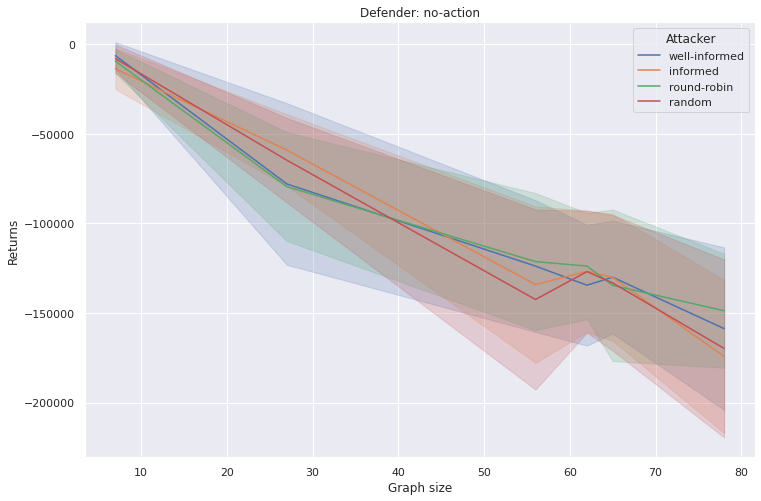

In [17]:
g = sns.lineplot(data=df, x='Graph size', y='Returns', hue='Attacker', ci='sd')
g.legend(title='Attacker', loc='upper right')
g.set_title('Defender: no-action')

Text(0.5, 1.0, 'Defender: no-action')

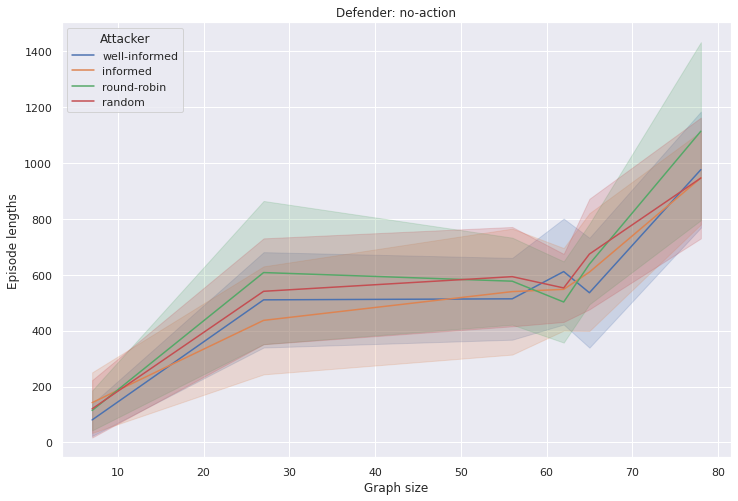

In [16]:
g = sns.lineplot(data=df, x='Graph size', y='Episode lengths', hue='Attacker', ci='sd')
g.legend(title='Attacker', loc='upper left')
g.set_title('Defender: no-action')